# TReNDS NeuroImaging
Prediction of multiple assessments plus age from multimodal brain MRI features using image analysis from IR representation of all the corresponding spatial maps. This notebook is for the data and feature visualization of the problem. 
<br>
<br>
More information about the project is found [here](https://www.kaggle.com/c/trends-assessment-prediction/overview/description)

In [3]:
import os


import random
import seaborn as sns
import cv2
# General packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL


import nilearn as nl
import nilearn.plotting as nlplt
import nibabel as nib
from nilearn import image
from nilearn import plotting
from nilearn import datasets
from nilearn import surface
import h5py
import plotly.graph_objs as go
from IPython.display import Image, display
#import joypy
import warnings
warnings.filterwarnings("ignore")


In [4]:
BASE_PATH = '../input/trends-assessment-prediction'

# image and mask directories
train_data_dir = f'{BASE_PATH}/fMRI_train'
test_data_dir = f'{BASE_PATH}/fMRI_test'


print('Reading data...')
loading_data = pd.read_csv(f'{BASE_PATH}/loading.csv')
train_data = pd.read_csv(f'{BASE_PATH}/train_scores.csv')
#test = pd.read_csv(test_data_dir)
submission_file = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
print('Reading data completed')

Reading data...
Reading data completed


# Viewing the data

In [5]:
display(train_data.head())
print("Shape of train_data :", train_data.shape)

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,NaN,NaN,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421


Shape of train_data : (5877, 6)


In [6]:
display(loading_data.head())
print("Shape of loading_data :", loading_data.shape)

,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,...,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14
0,10001,0.006070,0.014466,0.004136,0.000658,-0.002742,0.005033,0.016720,0.003484,0.001797,...,0.018246,0.023711,0.009177,-0.013929,0.030696,0.010496,0.002892,-0.023235,0.022177,0.017192
1,10002,0.009087,0.009291,0.007049,-0.002076,-0.002227,0.004605,0.012277,0.002946,0.004086,...,0.014635,0.022556,0.012004,-0.011814,0.022479,0.005739,0.002880,-0.016609,0.025543,0.014524
2,10003,0.008151,0.014684,0.010444,-0.005293,-0.002913,0.015042,0.017745,0.003930,-0.008021,...,0.019565,0.030616,0.018184,-0.010469,0.029799,0.015435,0.005211,-0.028882,0.031427,0.018164
3,10004,0.004675,0.000957,0.006154,-0.000429,-0.001222,0.011755,0.013010,0.000193,0.008075,...,0.002658,0.022266,0.005956,-0.010595,0.024078,-0.000319,0.005866,-0.015182,0.024476,0.014760
4,10005,-0.000398,0.006878,0.009051,0.000369,0.000336,0.010679,0.010352,0.003637,0.004180,...,0.009702,0.017257,0.005454,-0.008591,0.019416,0.000786,0.002692,-0.019814,0.017105,0.013316


Shape of loading_data : (11754, 27)


# Check for missing values

### *Train_scores* file

,Total,Percent
domain1_var2,438,0.074528
domain1_var1,438,0.074528
domain2_var2,39,0.006636
domain2_var1,39,0.006636
age,0,0.000000


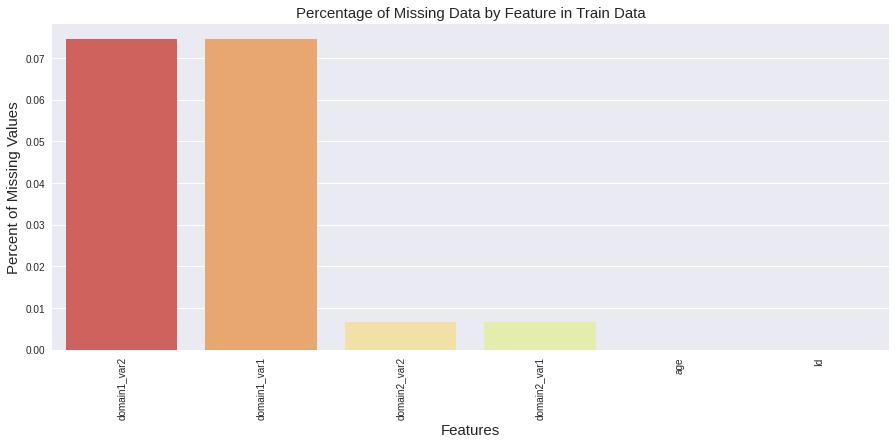

In [7]:
plt.style.use('seaborn')

total = train_data.isnull().sum().sort_values(ascending=False)
percent = (train_data.isnull().sum()/train_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'], palette='Spectral')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of Missing Values', fontsize=15)
plt.title('Percentage of Missing Data by Feature in Train Data', fontsize=15)
missing_data.head()


As seen from the plot, all of the domain features have missing values. Considering that the values of these features are numerical, these are replaced by the median value of the specific feature column 

In [8]:
train_data['domain1_var1'].fillna(train_data['domain1_var2'].median(), inplace = True)
train_data['domain1_var2'].fillna(train_data['domain1_var2'].median(), inplace = True)
train_data['domain2_var1'].fillna(train_data['domain1_var2'].median(), inplace = True)
train_data['domain2_var2'].fillna(train_data['domain1_var2'].median(), inplace = True)

### *loading* file

,Total,Percent
IC_14,0,0.0
IC_24,0,0.0
IC_01,0,0.0
IC_07,0,0.0
IC_05,0,0.0


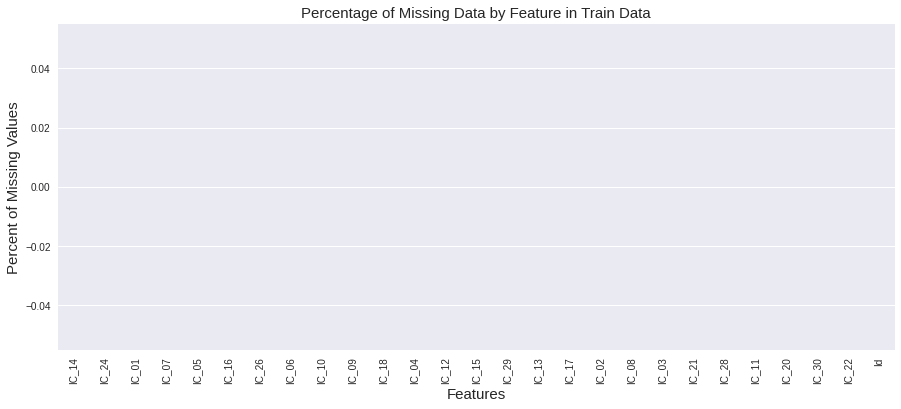

In [9]:
total = loading_data.isnull().sum().sort_values(ascending=False)
percent = (loading_data.isnull().sum()/loading_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'], palette='Spectral')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of Missing Values', fontsize=15)
plt.title('Percentage of Missing Data by Feature in Train Data', fontsize=15)
missing_data.head()


No missing values were encountered in the *loading_data* file so no basic feature engineering is necessary

# Data Visualization

## Age Distribution

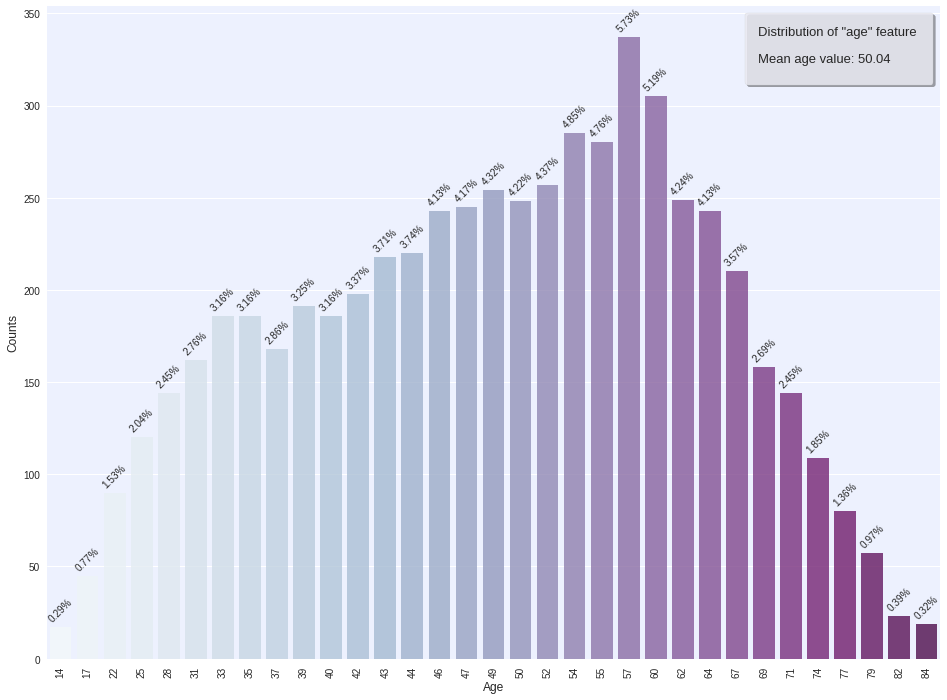

In [10]:
f, ax = plt.subplots(1,1, figsize=(16,12))
total = float(len(train_data))
barplot = sns.barplot(np.round(train_data['age'].value_counts().index).astype(int), train_data['age'].value_counts().values, alpha=0.8, palette='BuPu')
mean_age = np.mean(train_data['age'].value_counts().index)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center", rotation=45)
barplot.legend(fancybox=True, frameon = True, framealpha=0.85, shadow=True, borderpad=1, title=f'Distribution of "age" feature \n\nMean age value: {mean_age:.2f}', title_fontsize=13 , fontsize=13)
barplot.set_facecolor('#edf1fe')
plt.xlabel('Age', fontsize=12, )
plt.ylabel('Counts', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Correlation

### *train_scores* file

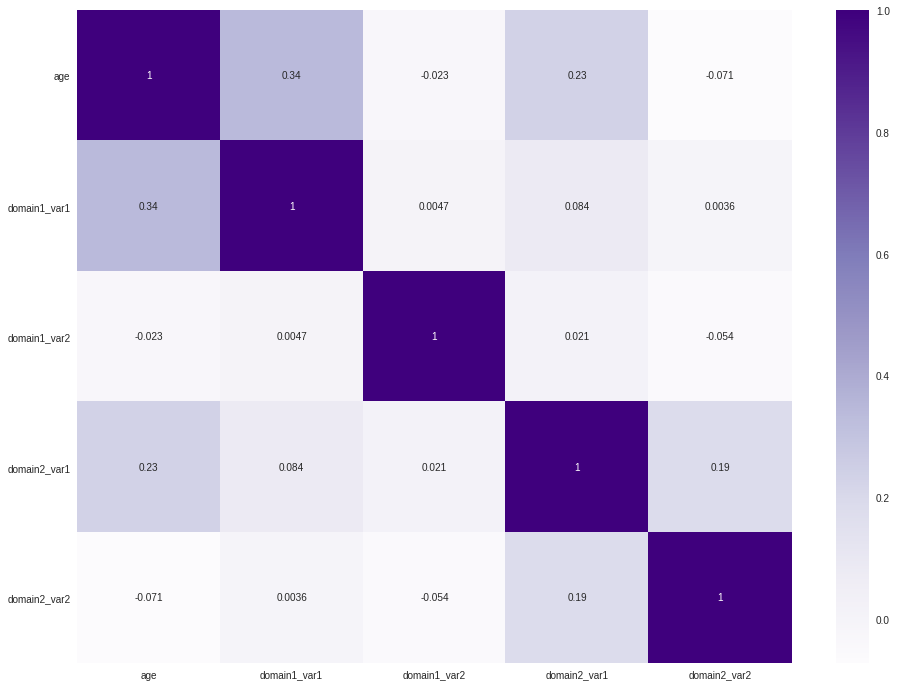

In [11]:
temp_data =  train_data.drop(['Id'], axis=1)

plt.figure(figsize = (16, 12))
sns.heatmap(temp_data.corr(), annot = True, cmap="Purples")
plt.yticks(rotation=0) 

plt.show()

As seen, the stronger correlations are between the features
* **age** and **domain1_var1** (0.34)
* **age** and **domain2_var1** (0.23)
* **domain2_var1** and **domain2_var2** (0.19)


### Visualization of correlation

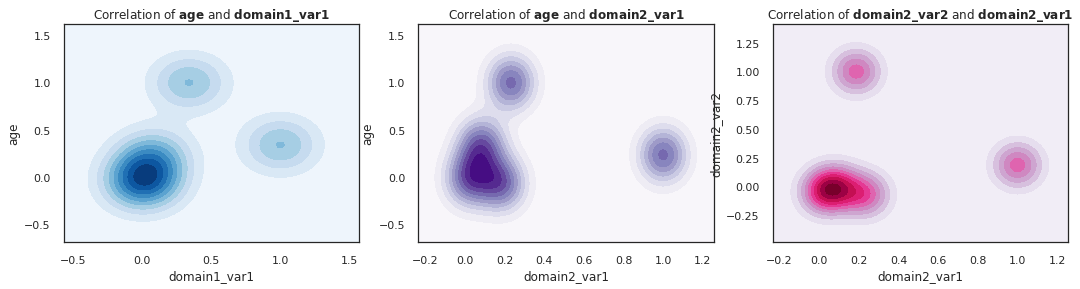

In [12]:
sns.set(style="white", color_codes=True)
f, ax = plt.subplots(1, 3, figsize=(18, 4), sharex=False)

sns.kdeplot(temp_data.corr()['domain1_var1'], temp_data.corr()['age'], cmap="Blues", shade=True, shade_lowest=True, ax=ax[0])
ax[0].set_title('Correlation of $\mathbf{age}$ and $\mathbf{domain1\_var1}$')

sns.kdeplot(temp_data.corr()['domain2_var1'], temp_data.corr()['age'], cmap="Purples", shade=True, shade_lowest=True, ax=ax[1])
ax[1].set_title('Correlation of $\mathbf{age}$ and $\mathbf{domain2\_var1}$')

sns.kdeplot(temp_data.corr()['domain2_var1'], temp_data.corr()['domain2_var2'], cmap="PuRd", shade=True, shade_lowest=True, ax=ax[2])
ax[2].set_title('Correlation of $\mathbf{domain2\_var2}$ and $\mathbf{domain2\_var1}$')

plt.show()

### *loading* file

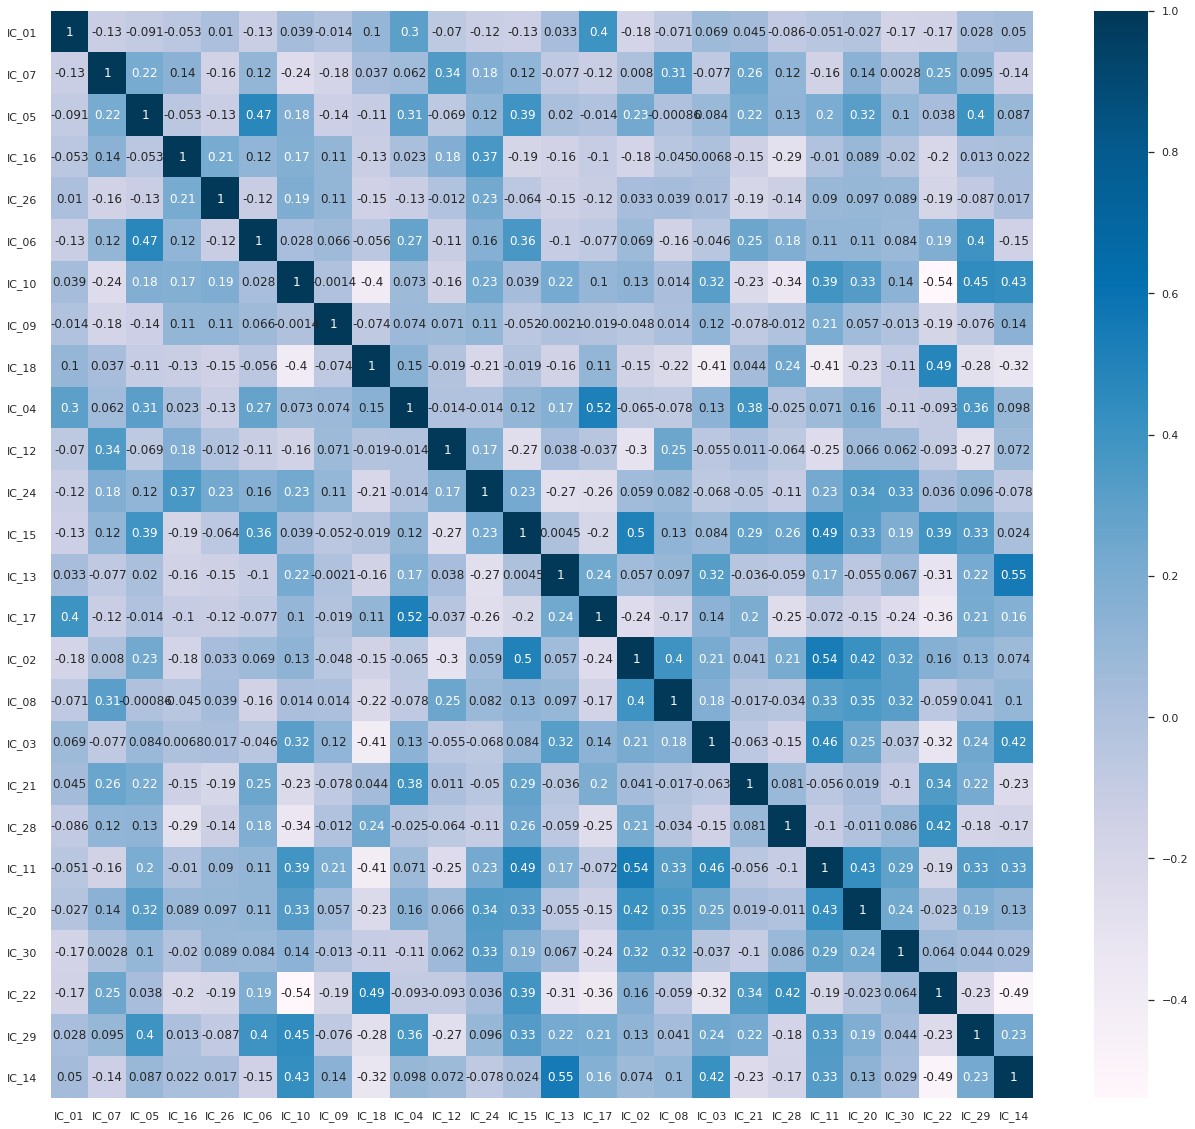

In [13]:
temp_data =  loading_data.drop(['Id'], axis=1)

plt.figure(figsize = (22, 20))
sns.heatmap(temp_data.corr(), annot = True, cmap="PuBu")
plt.yticks(rotation=0) 

plt.show()

From the matrix, the strongest correlations are between
* __IC_04__ and __IC_17__ (0.52)
* __IC_13__ and __IC_14__ (0.55)
* __IC_02__ and __IC_11__ (0.54)

which all have much higher correlation than the features from the training scores data


### Level of correlation

In [14]:
temp_data =  loading_data.drop(['Id'], axis=1)
# Create correlation matrix
correl = temp_data.corr().abs()

# Select upper triangle of correlation matrix
upper = correl.where(np.triu(np.ones(correl.shape), k=1).astype(np.bool))

weak_corr = [column for column in upper.columns if any(upper[column] >= 0.1) and any(upper[column] < 0.3)]
medium_corr = [column for column in upper.columns if any(upper[column] >= 0.3) and any(upper[column] <0.5)]
strong_corr = [column for column in upper.columns if any(upper[column] >= 0.5)]


print(f'Weak correlation features [0.1, 0.3):\n{weak_corr}\n')
print(f'Medium correlation features [0.3, 0.5):\n{medium_corr}\n')
print(f'Strong correlation features [0.5, 1.0]:\n{strong_corr}')


Weak correlation features [0.1, 0.3):
['IC_07', 'IC_05', 'IC_16', 'IC_26', 'IC_06', 'IC_10', 'IC_09', 'IC_18', 'IC_04', 'IC_12', 'IC_24', 'IC_15', 'IC_13', 'IC_17', 'IC_02', 'IC_08', 'IC_03', 'IC_21', 'IC_28', 'IC_11', 'IC_20', 'IC_30', 'IC_22', 'IC_29', 'IC_14']

Medium correlation features [0.3, 0.5):
['IC_06', 'IC_18', 'IC_04', 'IC_12', 'IC_24', 'IC_15', 'IC_17', 'IC_02', 'IC_08', 'IC_03', 'IC_21', 'IC_28', 'IC_11', 'IC_20', 'IC_30', 'IC_22', 'IC_29', 'IC_14']

Strong correlation features [0.5, 1.0]:
['IC_17', 'IC_02', 'IC_11', 'IC_22', 'IC_14']


# Spatial map visualization with [nilearn](https://nilearn.github.io/)
"Nilearn is a Python module for fast and easy statistical learning on NeuroImaging data.

It leverages the scikit-learn Python toolbox for multivariate statistics with applications such as predictive modelling, classification, decoding, or connectivity analysis."
<br>
<br>
The spatial maps are stored in h5py files and are 4D tensors of $\left(N_{SM} \times X \times Y \times Z \right)$, where $N_{SM}$ is the number of spatial maps and $X,Y,Z$ are the space coordinates. 

In [15]:
mask_filename = f'{BASE_PATH}/fMRI_mask.nii'
subject_filename = '../input/trends-assessment-prediction/fMRI_train/10004.mat'
smri_filename = '/kaggle/input/trends-assessment-prediction/fMRI_mask.nii'
mask_niimg = nl.image.load_img(mask_filename)


def load_subject(filename, mask_niimg):
    subject_data = None
    with h5py.File(subject_filename, 'r') as f:
        subject_data = f['SM_feature'][()]
    # It's necessary to reorient the axes, since h5py flips axis order
    subject_data = np.moveaxis(subject_data, [0,1,2,3], [3,2,1,0])
    subject_niimg = nl.image.new_img_like(mask_niimg, subject_data, affine=mask_niimg.affine, copy_header=True)
    return subject_niimg


Image shape is (53, 63, 52, 53)
Detected 53 spatial maps


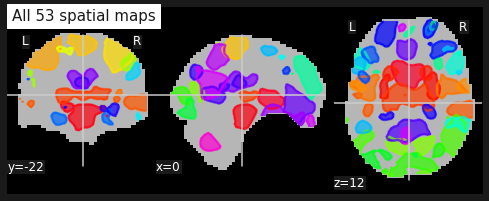

In [16]:
import random

files = random.choices(os.listdir('../input/trends-assessment-prediction/fMRI_train/'), k=1)
for file in files:
    subject_niimg = load_subject(file, mask_niimg)
    print(f"Image shape is {str(subject_niimg.shape)}" )
    num_sm = subject_niimg.shape[-1]
    print(f"Detected {num_sm} spatial maps")
    nlplt.plot_prob_atlas(subject_niimg, 
                      bg_img=smri_filename, 
                      view_type='filled_contours', 
                      draw_cross=True,
                      title=f'All {num_sm} spatial maps', 
                      threshold='auto')

### IR representation of the activation of each spatial map from subject above

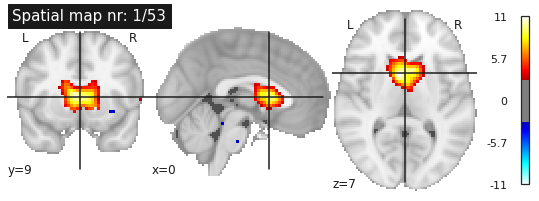

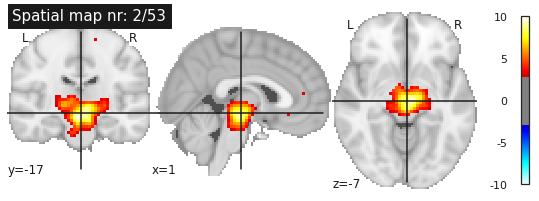

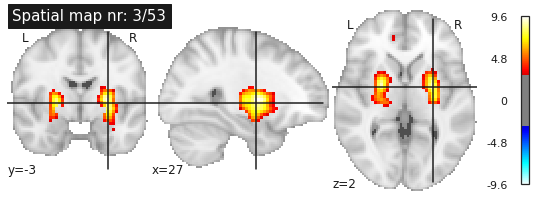

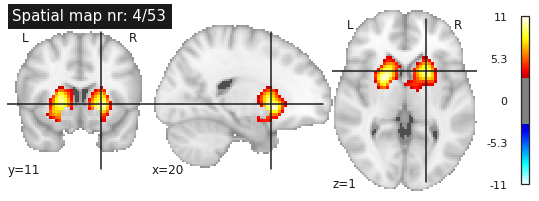

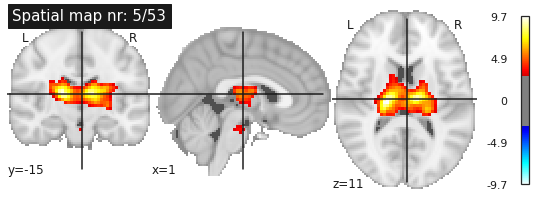

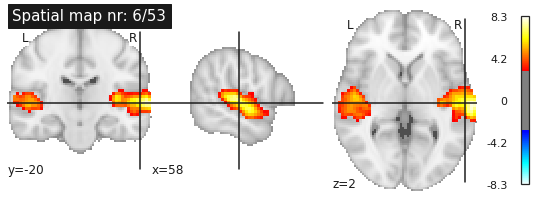

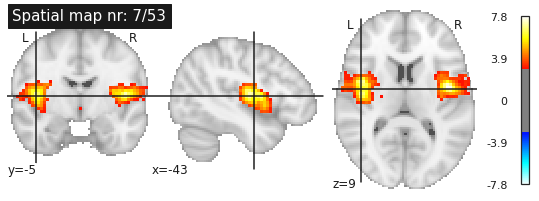

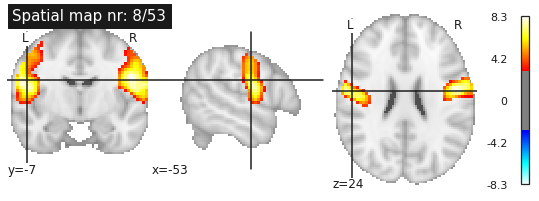

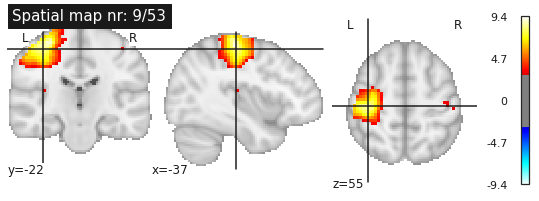

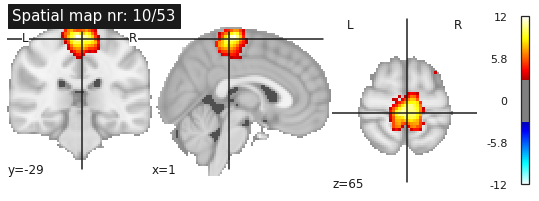

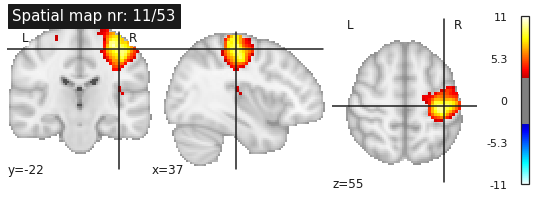

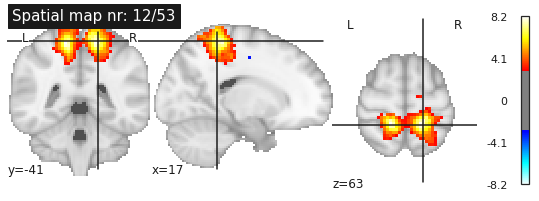

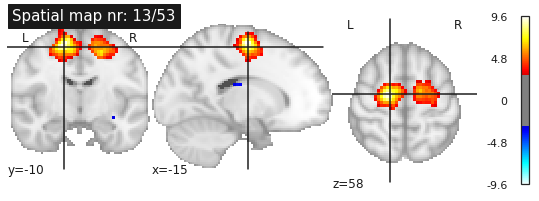

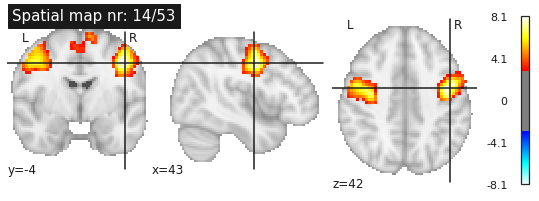

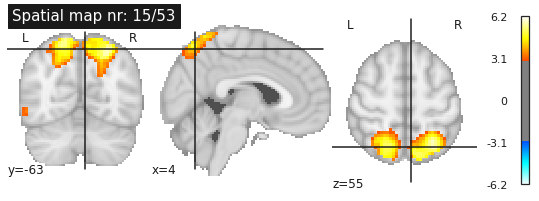

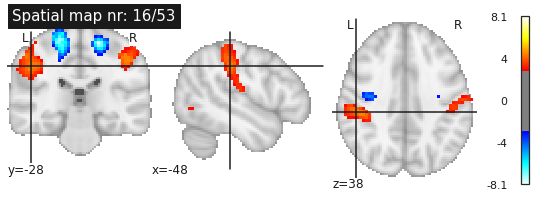

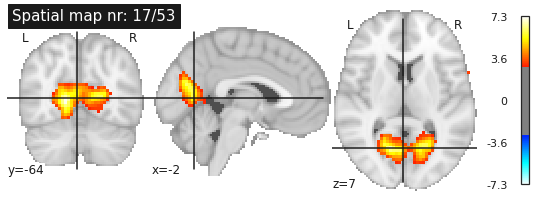

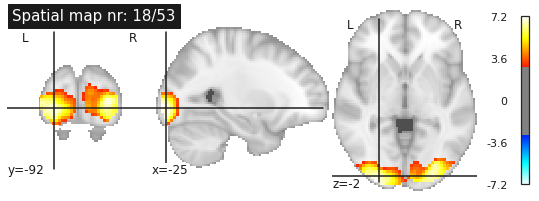

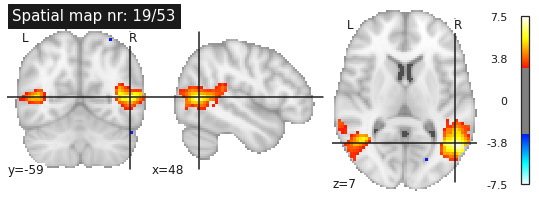

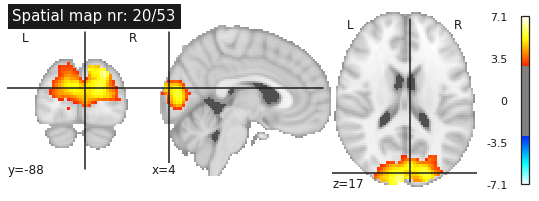

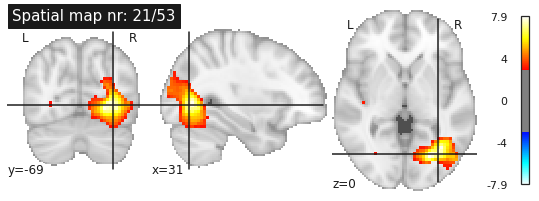

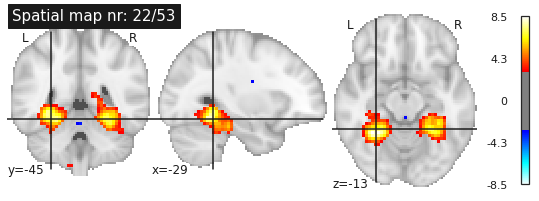

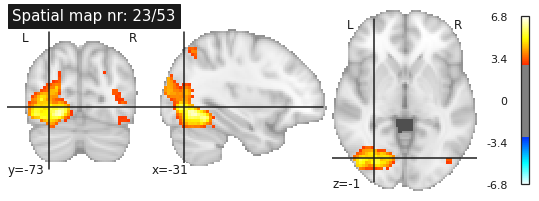

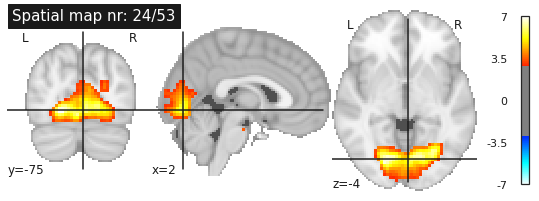

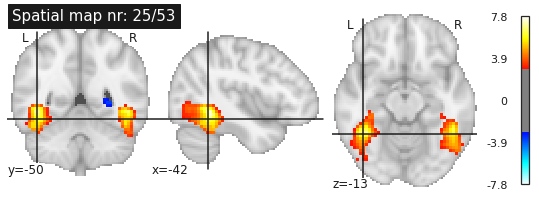

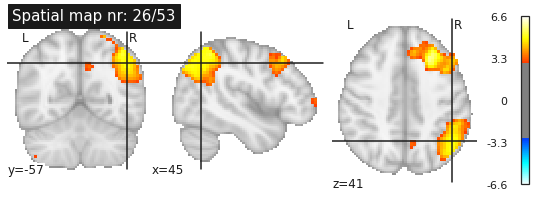

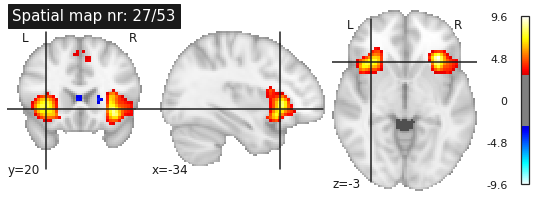

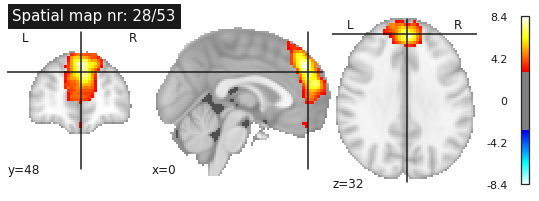

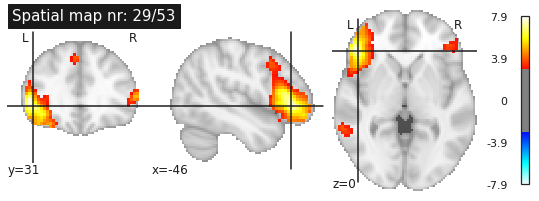

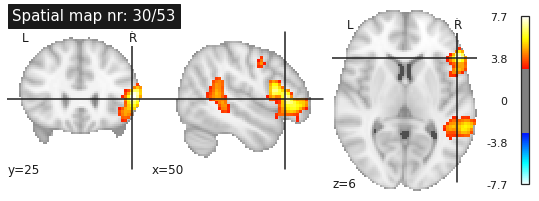

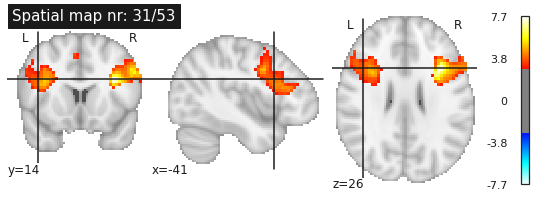

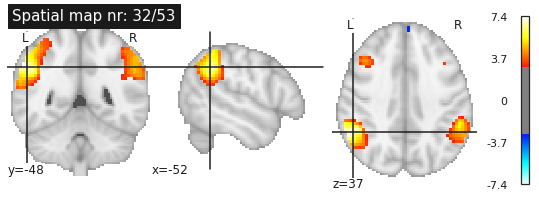

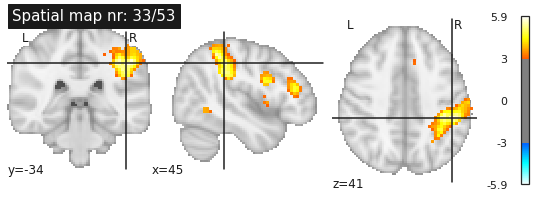

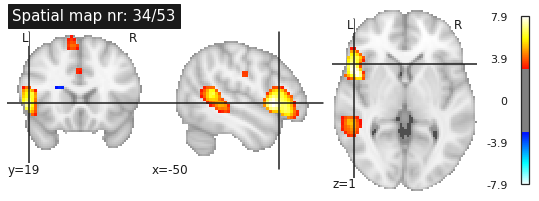

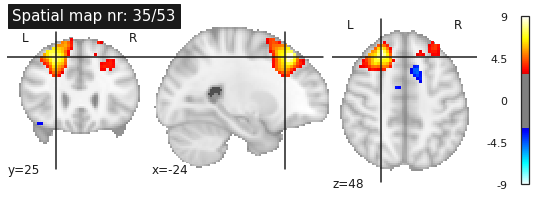

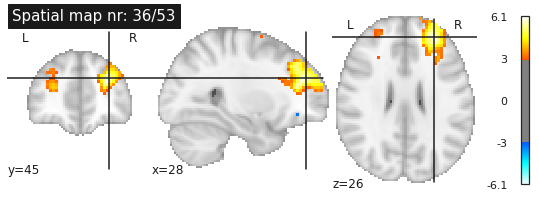

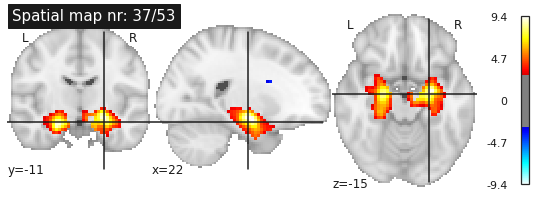

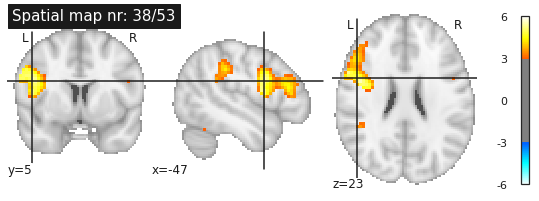

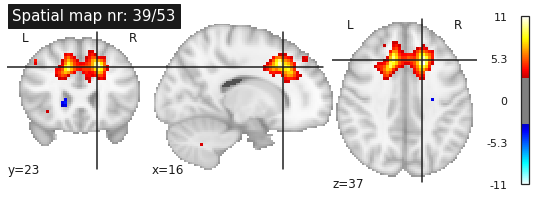

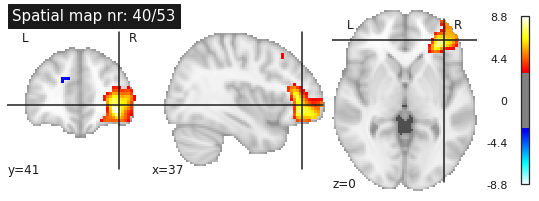

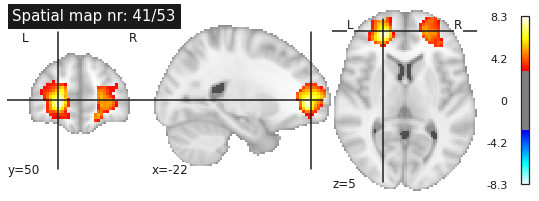

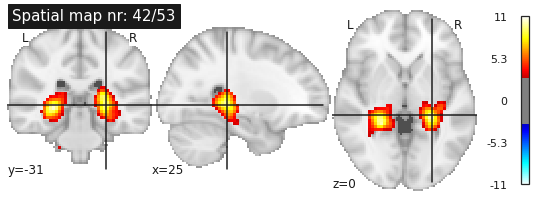

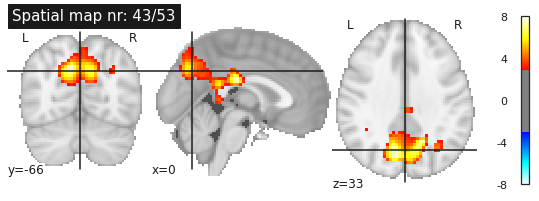

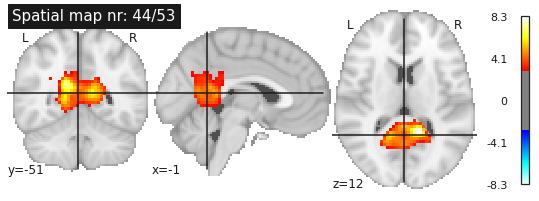

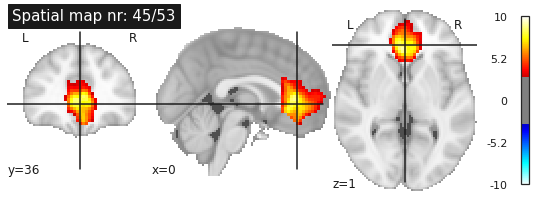

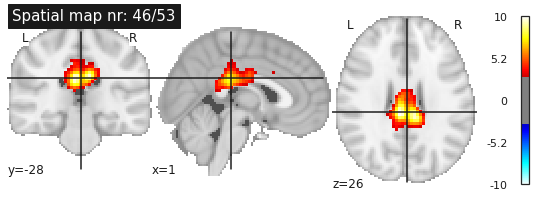

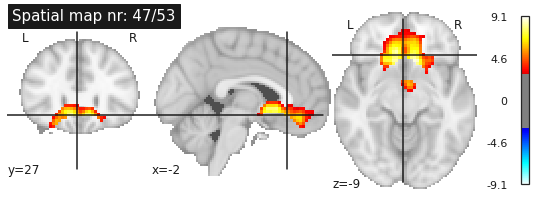

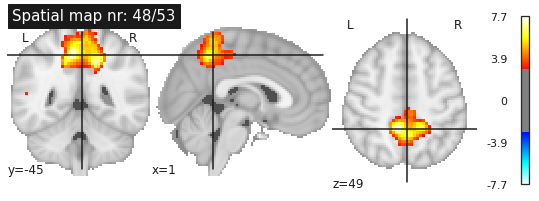

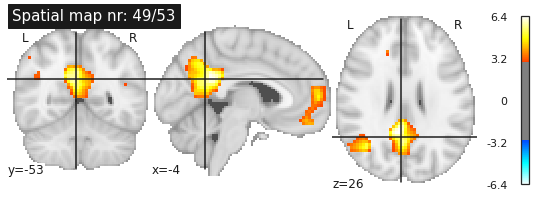

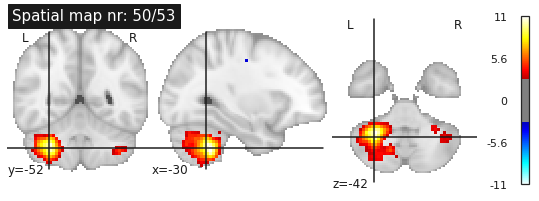

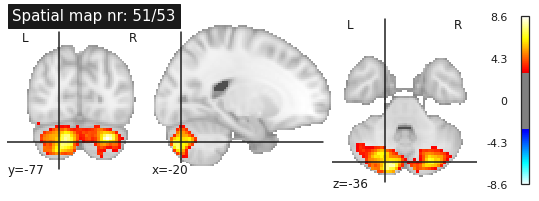

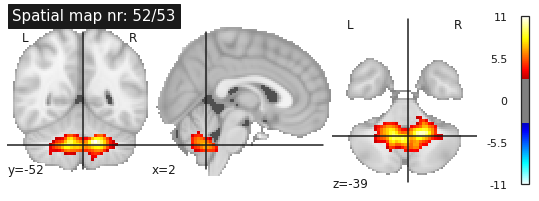

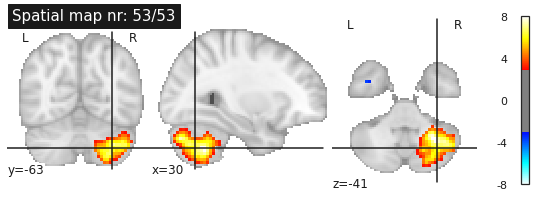

In [17]:
for file in files:
    subject = os.path.join('../input/trends-assessment-prediction/fMRI_train/', file)
    subject_img = load_subject(subject, mask_niimg)
    num_sm = subject_img.shape[-1]
    rsn = subject_img
    #convert to 3d image
    first_rsn = image.index_img(rsn, 0)
    for idx, img in enumerate(image.iter_img(rsn)):
        # img is now an in-memory 3D img
        plot = plotting.plot_stat_map(img, threshold=3)
        plot.title(f'Spatial map nr: {idx+1}/{num_sm}')
